In [3]:
import matplotlib.pyplot as plt

from fitting import create_ensemble, load_data, create_datasets
from phase_space_reconstruction.utils import get_core_fraction
import torch

tkwargs = {"dtype": torch.float}
save_dir = "mse_scale_1_run3_cov_term"
quad_strengths, image_data, bins, xx = load_data(tkwargs)
train_dset = torch.load(save_dir + "/train.dset")
test_dset = torch.load(save_dir + "/test.dset")

bin_width = bins[1] - bins[0]
bandwidth = bin_width / 2
ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, save_dir)

ensemble.cuda();

frac = 1.0
s = slice(0,4)

# get beam reconstruction from slit scan measurement
import numpy as np
meas_y = torch.tensor(np.load("y_recon.npy"))
meas_yp = torch.tensor(np.load("yp_recon.npy"))
slit_data = torch.stack([meas_y, meas_yp]).T
slit_core = get_core_fraction(slit_data,frac)

covs = []
for i in range(4):
    initial_beam = ensemble[i].beam().data
    re_core = get_core_fraction(initial_beam,frac,s)

    covs += [torch.cov(re_core.T)]

covs = torch.stack(covs)
covs.shape



torch.Size([4, 6, 6])

In [4]:
xemittances = torch.det(covs[:,:2,:2]).sqrt()*1e6 * 63/0.511
yemittances = torch.det(covs[:,2:4,2:4]).sqrt()*1e6 * 63/0.511
print(f"enx {xemittances.mean()} +/- {xemittances.std()}")
print(f"eny {yemittances.mean()} +/- {yemittances.std()}")

print(torch.cov(slit_data.T).det().sqrt()*1e6 * 63/0.511)


enx 5.287405967712402 +/- 0.2864671051502228
eny 4.306819438934326 +/- 0.16332578659057617
tensor(3.9027, dtype=torch.float64)


In [3]:
xemittances

tensor([11.5553,  7.7821,  6.7819,  6.3890,  6.1670], device='cuda:0',
       grad_fn=<DivBackward0>)

In [4]:
yemittances

tensor([4.2427, 4.1933, 4.2570, 4.2860, 4.2622], device='cuda:0',
       grad_fn=<DivBackward0>)

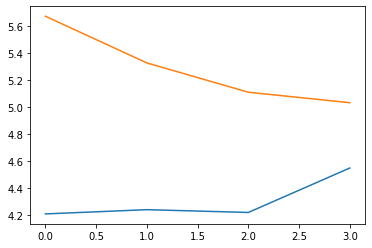

In [5]:
plt.plot(yemittances.cpu().detach())
plt.plot(xemittances.cpu().detach())

In [6]:
reconstruction_data = initial_beam.data




gt_cov = torch.cov(gt_core.T)
re_cov = torch.cov(re_core.T)

print(torch.det(gt_cov[:2,:2]).sqrt())
print(torch.det(re_cov[:2,:2]).sqrt())

print(torch.det(gt_cov[2:4,2:4]).sqrt())
print(torch.det(re_cov[2:4,2:4]).sqrt())

NameError: name 'gt_core' is not defined

In [ ]:
plt.plot(*gt_core.T[:2,::100].cpu().detach(), '.')
plt.plot(*re_core.T[:2,::100].cpu().detach(), '.')

plt.figure()
plt.plot(*gt_core.T[2:4,::100].cpu().detach(), '.')
plt.plot(*re_core.T[2:4,::100].cpu().detach(), '.')